In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error

from utils.train import create_dataloader, train
from models import cVAE, cLSTM

### Load/Process Data:

In [2]:
class SequenceDataset(TensorDataset):
    def __init__(self, data,sequence_length=4):
        self.data = data.astype('float64')
        self.sequence_length = sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.data[idx:idx+self.sequence_length])      
        sample_output = torch.tensor(self.data[idx+1:idx+self.sequence_length+1])

        return sample_input[:,None,:], sample_output[:,None,:]
    
    def __len__(self):
        return len(self.data) - self.sequence_length

Note: I'm training with sequence_length (i.e. window) = 1 which doesn't really make sense for an LSTM but I think it's what they want!

In [3]:
train_path = 'data/Ferguson_fire_train.npy'
train_data = np.load(train_path)
train_dataset = SequenceDataset(train_data, sequence_length=1)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_path = 'data/Ferguson_fire_test.npy'
val_data = np.load(val_path)
val_dataset = SequenceDataset(val_data, sequence_length=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Train (ConvLSTM) Model:

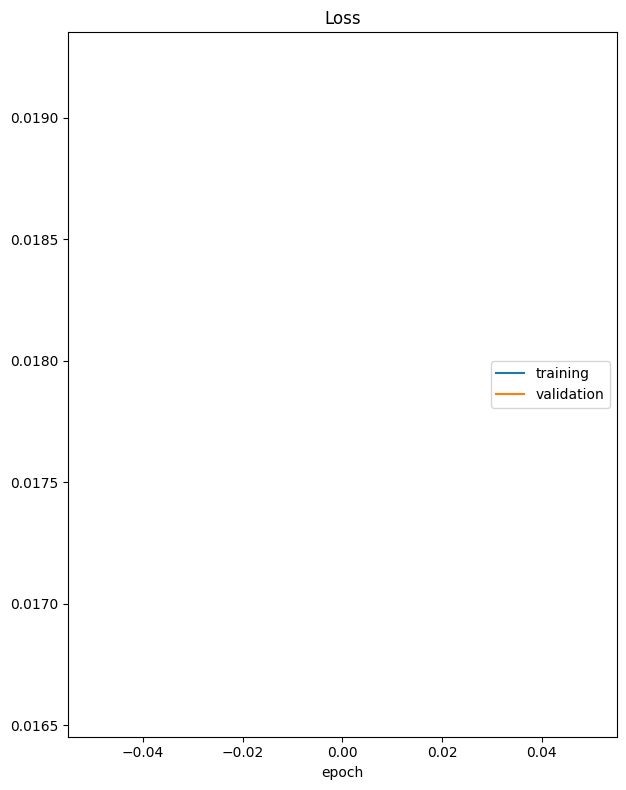

Loss
	training         	 (min:    0.019, max:    0.019, cur:    0.019)
	validation       	 (min:    0.017, max:    0.017, cur:    0.017)
Epoch 2 of 20
Train:


 63%|██████████████████████████               | 248/391 [09:54<05:40,  2.38s/it]

In [ ]:
device = 'cpu'
n_layers = 1

sequence_length = 1
channels = 1
epochs = 20
clstm = cLSTM.ConvLSTM(input_dim=channels,
                 hidden_dim=16,
                 kernel_size=(3, 3),
                 num_layers=1,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)

if not os.path.exists('models/clstm.pt'):
    clstm = train(clstm, train_loader, val_loader, epochs=epochs, device=device)
    if not os.path.exists('models/'):
        os.makedirs('models/')
    torch.save(clstm.state_dict(), 'models/clstm.pt')
else:
    clstm.load_state_dict(torch.load('models/clstm.pt'))

### Plot validation results (actual vs forecasted):

In [ ]:
# images, labels = next(iter(train_loader))
# cvae.eval()

# fig, ax = plt.subplots(2, 5, figsize=[18.5, 6])
# fig.tight_layout(pad=4)
# for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
#     recon, _ = cvae(images[idx].unsqueeze(0)) 
#     ax[0, n].imshow(labels[idx].squeeze())
#     ax[0, n].axis('off')
#     ax[1, n].imshow(recon.cpu().detach().squeeze())
#     ax[1, n].axis('off')
#     if n==0:
#         ax[0,n].set_title('(Val) Actual:', fontsize=20, pad=20, loc='left')
#         ax[1,n].set_title('(Val) Forecasted:', fontsize=20, pad=20, loc='left')

### Plot test results (actual vs forecasted):

In [ ]:
# test_path = 'data/Ferguson_fire_obs.npy'
# test_data = np.array(np.load(open(test_path,'rb')))
# test_data_shifted = torch.Tensor(test_data[1:])
# test_data = torch.Tensor(test_data[:-1])
# test_dataset = TensorDataset(test_data,test_data_shifted)

In [ ]:
# fig, ax = plt.subplots(2, 4, figsize=[18.5, 6])
# fig.tight_layout(pad=4)
# mses = []
# for n,(image,label) in enumerate(test_dataset):
#     recon, _ = cvae(image.unsqueeze(0)) 
#     mses.append(mean_squared_error(label.flatten(),recon.cpu().detach().squeeze().flatten()))
#     ax[0, n].axis('off')
#     ax[0, n].imshow(label.squeeze())
#     ax[1, n].imshow(recon.cpu().detach().squeeze())
#     ax[1, n].axis('off')
#     if n==0:
#         ax[0,n].set_title('(Test) Actual:', fontsize=20, pad=20, loc='left')
#         ax[1,n].set_title('(Test) Forecasted:', fontsize=20, pad=20, loc='left')

### MSE test:

In [ ]:
# print(f'(Test) MSE: {sum(mses)/len(test_dataset)}')